# Using rail_fsps to generate galaxy rest-frame spectral energy distributions and  compute apparent magnitudes

author: Luca Tortorelli, Josue de Santiago, Eric Charles
    
last run successfully: Aug 2nd, 2023
    
This notebook demonstrates how to use rail_fsps to generate galaxy rest-frame spectral energy distributions (SEDs) with FSPS and how to compute apparent magnitudes from them.

In order to run this notebook you need to have FSPS and Python-FSPS installed. The easiest way to do this is the following (first line applies only in case you already installed it via pip):

    pip uninstall fsps
    git clone --recursive https://github.com/dfm/python-fsps.git
    cd python-fsps
    python -m pip install .
    export SPS_HOME=$(pwd)/src/fsps/libfsps

In [1]:
import os
from rail.core.data import TableHandle
from rail.creation.engines.fsps_sed_modeler import *
import rail.fsps
import h5py
import numpy as np

We'll start by setting up the Rail data store. RAIL uses ceci, which is designed for pipelines rather than interactive notebooks, the data store will work around that and enable us to use data interactively. See the rail/examples/goldenspike/goldenspike.ipynb example notebook for more details on the Data Store.

In [2]:
from rail.core.stage import RailStage
DS = RailStage.data_store
DS.__class__.allow_overwrite = True
RAIL_FSPS_DIR = os.path.abspath(os.path.join(os.path.dirname(rail.fsps.__file__), '..', '..'))
default_rail_fsps_files_folder = os.path.join(RAIL_FSPS_DIR, 'rail', 'examples_data', 'creation_data', 'data',
                                              'fsps_default_data')
input_file = os.path.join(default_rail_fsps_files_folder, 'input_galaxy_properties_fsps.hdf5')

We generate some mock input data for the sed modeler class that we store in an hdf5 file.

In [3]:
n_galaxies = 10

redshifts = np.linspace(0.1,1,num=n_galaxies)
zmet = np.full(n_galaxies, 1, dtype=int)
stellar_metallicity = np.full(n_galaxies, 0.0) # log10(Z/Zsun)
pmetals = np.full(n_galaxies, 2.0)
stellar_velocity_dispersion = np.full(n_galaxies, 100.)
gas_ionization = np.full(n_galaxies, -1)
gas_metallicity = np.full(n_galaxies, 0.0)
tau = np.full(n_galaxies, 1.0)
const = np.full(n_galaxies, 0.0)
sf_start = np.full(n_galaxies, 0.0)
sf_trunc = np.full(n_galaxies, 0.0)
stellar_age = np.full(n_galaxies, 2.)
fburst = np.full(n_galaxies, 0.0)
tburst = np.full(n_galaxies, 11.0)
sf_slope = np.full(n_galaxies, 0.0)
dust1_birth_cloud = np.full(n_galaxies, 0.1)
dust2_diffuse = np.full(n_galaxies, 0.1)
dust_index = np.full(n_galaxies, -0.7)
dust_calzetti_modifier = np.full(n_galaxies, -1.)
mwr = np.full(n_galaxies, 3.1)
uvb = np.full(n_galaxies, 1.0)
wgp1 = np.full(n_galaxies, 1)
dust_gamma = np.full(n_galaxies, 0.01)
dust_umin = np.full(n_galaxies, 1.0)
dust_qpah = np.full(n_galaxies, 3.5)
f_agn = np.full(n_galaxies, 0.01)
tau_agn = np.full(n_galaxies, 10.0)

gal_t_table = np.linspace(0.05, 13.8, 100) # age of the universe in Gyr
gal_sfr_table = np.random.uniform(0, 10, gal_t_table.size) # SFR in Msun/yr
tabulated_sfh = np.full((n_galaxies, 2, len(gal_sfr_table)), [gal_t_table,gal_sfr_table])

wave_lsf = np.linspace(3000, 10000, 2000)
sigma_lsf = np.full_like(wave_lsf, 0.5)
tabulated_lsf = np.full((n_galaxies, 2, len(wave_lsf)), [wave_lsf, sigma_lsf])

with h5py.File(input_file, 'w') as h5table:
    data = h5table.create_group('model')
    data.create_dataset(name='redshifts', data=redshifts)
    data.create_dataset(name='zmet', data=zmet)
    data.create_dataset(name='stellar_metallicity', data=stellar_metallicity)
    data.create_dataset(name='pmetals', data=pmetals)
    data.create_dataset(name='stellar_velocity_dispersion', data=stellar_velocity_dispersion)
    data.create_dataset(name='gas_ionization', data=gas_ionization)
    data.create_dataset(name='gas_metallicity', data=gas_metallicity)
    data.create_dataset(name='tau', data=tau)
    data.create_dataset(name='const', data=const)
    data.create_dataset(name='sf_start', data=sf_start)
    data.create_dataset(name='sf_trunc', data=sf_trunc)
    data.create_dataset(name='stellar_age', data=stellar_age)
    data.create_dataset(name='fburst', data=fburst)
    data.create_dataset(name='tburst', data=tburst)
    data.create_dataset(name='sf_slope', data=sf_slope)
    data.create_dataset(name='dust1_birth_cloud', data=dust1_birth_cloud)
    data.create_dataset(name='dust2_diffuse', data=dust2_diffuse)
    data.create_dataset(name='dust_index', data=dust_index)
    data.create_dataset(name='dust_calzetti_modifier', data=dust_calzetti_modifier)
    data.create_dataset(name='mwr', data=mwr)
    data.create_dataset(name='uvb', data=uvb)
    data.create_dataset(name='wgp1', data=wgp1)
    data.create_dataset(name='dust_gamma', data=dust_gamma)
    data.create_dataset(name='dust_umin', data=dust_umin)
    data.create_dataset(name='dust_qpah', data=dust_qpah)
    data.create_dataset(name='f_agn', data=f_agn)
    data.create_dataset(name='tau_agn', data=tau_agn)
    data.create_dataset(name='tabulated_lsf', data=tabulated_lsf)
    data.create_dataset(name='tabulated_sfh', data=tabulated_sfh)

Here we load the data to the data store to use it later, and we also set the redshifts in which the output will be generated.

In [4]:
trainFile = os.path.join(input_file)
training_data = DS.read_file("training_data", TableHandle, trainFile)

Let's create an FSPSSedModeler class object. The latter has a number of configuration parameters to set. All the parameters have default values. Therefore, if the user is not sure about a particular value for a certain parameter, the latter can be left at default. A short description of each parameter can be found in src/rail/creation/engines/fsps_sed_modeler.py. 

We run the FSPSSedModeler in sequential mode. Note that each galaxy spectrum takes a few seconds to generate, so it is advisable to proceed in this way only for a limited sample of objects or for testing the code.

In [5]:
fspssedmodeler = FSPSSedModeler.make_stage(chunk_size=10, hdf5_groupname='model', name='FSPSSedModeler',
                                           compute_vega_mags=False,vactoair_flag=False,
                                           zcontinuous=1, add_agb_dust_model=True,
                                           add_dust_emission=True, add_igm_absorption=True,
                                           add_neb_emission=True, add_neb_continuum=True,
                                           add_stellar_remnants=True, compute_light_ages=False,
                                           nebemlineinspec=True, smooth_velocity=True,
                                           smooth_lsf=False, cloudy_dust=False,
                                           agb_dust=1.0, tpagb_norm_type=2, dell=0.0,
                                           delt=0.0, redgb=1.0, agb=1.0, fcstar=1.0, sbss=0.0,
                                           fbhb=0.0, pagb=1.0, redshifts_key='redshifts',
                                           zmet_key='zmet', stellar_metallicities_key='stellar_metallicity',
                                           pmetals_key='pmetals', imf_type=1, imf_upper_limit=120.,
                                           imf_lower_limit=0.08, imf1=1.3, imf2=2.3,imf3=2.3,vdmc=0.08,
                                           mdave=0.5,evtype=-1,use_wr_spectra=1,logt_wmb_hot=0.0,masscut=150.0,
                                           velocity_dispersions_key='stellar_velocity_dispersion',min_wavelength=3000,
                                           max_wavelength=10000,gas_ionizations_key='gas_ionization',
                                           gas_metallicities_key='gas_metallicity',igm_factor=1.0,sfh_type=3,
                                           tau_key='tau',const_key='const',sf_start_key='sf_start',
                                           sf_trunc_key='sf_trunc',stellar_ages_key='stellar_age',
                                           fburst_key='fburst',tburst_key='tburst',sf_slope_key='sf_slope',
                                           dust_type=2,dust_tesc=7.0,dust_birth_cloud_key='dust1_birth_cloud',
                                           dust_diffuse_key='dust2_diffuse',dust_clumps=-99,frac_nodust= 0.0,
                                           frac_obrun=0.0,dust_index_key='dust_index',
                                           dust_powerlaw_modifier_key='dust_calzetti_modifier',mwr_key='mwr',
                                           uvb_key='uvb',wgp1_key='wgp1',wgp2=1,wgp3=1,
                                           dust_emission_gamma_key='dust_gamma',dust_emission_umin_key='dust_umin',
                                           dust_emission_qpah_key='dust_qpah',fraction_agn_bol_lum_key='f_agn',
                                           agn_torus_opt_depth_key='tau_agn',tabulated_sfh_key='tabulated_sfh',
                                           tabulated_lsf_key='tabulated_lsf',physical_units=False,
                                           restframe_wave_key='restframe_wavelengths',
                                           restframe_sed_key='restframe_seds')

Here we show the example where we provide tabulated star-formation histories to generate the final SED. In this case, FSPS outputs the emission per total stellar mass. We call the fit_model() function to generate the model SEDs.

In [6]:
fspssedmodel = fspssedmodeler.fit_model(training_data)

Process 0 running creator on chunk 0 - 10
Inserting handle into data store.  model_FSPSSedModeler: inprogress_model_FSPSSedModeler.hdf5, FSPSSedModeler


In [7]:
fspssedmodel.data

{'restframe_wavelengths': array([[3010., 3030., 3050., ..., 9950., 9970., 9990.]]),
 'restframe_seds': array([[1.42759482e-05, 1.43249559e-05, 1.43778481e-05, ...,
         4.96154709e-05, 4.99308850e-05, 4.99859566e-05],
        [1.42759482e-05, 1.43249559e-05, 1.43778481e-05, ...,
         4.96154709e-05, 4.99308850e-05, 4.99859566e-05],
        [1.42759482e-05, 1.43249559e-05, 1.43778481e-05, ...,
         4.96154709e-05, 4.99308850e-05, 4.99859566e-05],
        ...,
        [1.42759482e-05, 1.43249559e-05, 1.43778481e-05, ...,
         4.96154709e-05, 4.99308850e-05, 4.99859566e-05],
        [1.42759482e-05, 1.43249559e-05, 1.43778481e-05, ...,
         4.96154709e-05, 4.99308850e-05, 4.99859566e-05],
        [1.42759482e-05, 1.43249559e-05, 1.43778481e-05, ...,
         4.96154709e-05, 4.99308850e-05, 4.99859566e-05]]),
 'redshifts': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

We plot the first spectrum to check that the SED generation worked correctly.

In [8]:
with h5py.File('model_FSPSSedModeler.hdf5','r') as h5table:
    for key in h5table.keys():
        print(key)
    redshifts = h5table['redshifts'][()]
    restframe_seds = h5table['restframe_seds'][()]
    restframe_wavelengths = h5table['restframe_wavelengths'][()]

redshifts
restframe_seds
restframe_wavelengths


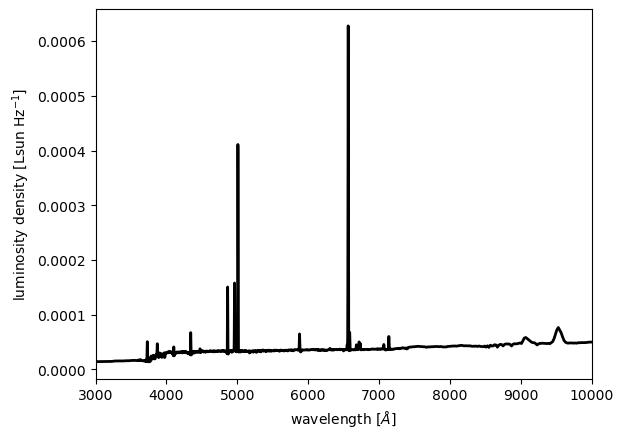

In [9]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(restframe_wavelengths[0], restframe_seds[0], lw=2, color='black')
plt.xlim(3000, 10000)
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'luminosity density [$\mathrm{Lsun \ Hz^{-1}}$]')
plt.show()

Running it with ceci

In [10]:
import ceci
pipe = ceci.Pipeline.interactive()
stages = [fspssedmodeler]
for stage in stages:
    pipe.add_stage(stage)

In [11]:
help(pipe.initialize)

Help on method initialize in module ceci.pipeline:

initialize(overall_inputs, run_config, stages_config) method of ceci.pipeline.MiniPipeline instance
    Load the configuation for this pipeline
    
    Parameters
    ----------
    overall_inputs : `Mapping`
        A mapping from tag to path for all of the overall inputs needed by this pipeline
    run_config : `Mapping`
        Configuration parameters for how to run the pipeline
    stages_config: `str`
        File with stage configuration parameters
    
    Returns
    -------
    self.run_info : information on how to run the pipeline, as provided by sub-class `initiate_run` method
    self.run_config : copy of configuration parameters on how to run the pipeline



In [12]:
pipe.initialize(
    dict(training_data=trainFile), 
    dict(
        output_dir='./temp_output_rail_fsps', 
        log_dir='./logs_rail_fsps',
        resume=False, 
        nprocess=2
    ), 
    None
)
pipe.save('./temp_output_rail_fsps/pipe_saved.yml')

In [13]:
import ceci
pr = ceci.Pipeline.read('./temp_output_rail_fsps/pipe_saved.yml')
pr.run()


Executing FSPSSedModeler
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.fsps_sed_modeler.FSPS_sed_model   --input=/Users/orl/code/DESC-RAIL/rail_fsps/src/rail/examples_data/creation_data/data/fsps_default_data/input_galaxy_properties_fsps.hdf5   --name=FSPSSedModeler   --config=./temp_output_rail_fsps/pipe_saved_config.yml   --model=./temp_output_rail_fsps/model_FSPSSedModeler.hdf5 
Output writing to ./logs_rail_fsps/FSPSSedModeler.out

Job FSPSSedModeler has completed successfully!


0

In [14]:
import tables_io
rest_frame_sed_models = tables_io.read('temp_output_rail_fsps/model_FSPSSedModeler.hdf5')

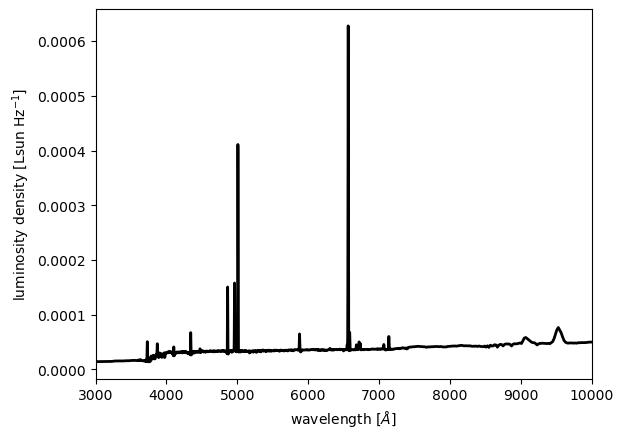

In [15]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(rest_frame_sed_models['restframe_wavelengths'][0], rest_frame_sed_models['restframe_seds'][1],
         lw=2, color='black')
plt.xlim(3000, 10000)
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'luminosity density [$\mathrm{Lsun \ Hz^{-1}}$]')
plt.show()

Now we use these rest-frame SEDs to generate LSST photometry at user-provided redshifts.
For this we need the FSPSPhotometryCreator class. The class parameters are:
- redshifts_key: redshift keyword for the Hdf5 input table.
- restframe_sed_key: rest-frame sed keyword for the Hdf5 input table.
- restframe_wave_key: wavelength keyword for the Hdf5 input table.
- apparent_mags_key: apparent magnitudes keyword for the Hdf5 output table.
- filter_folder: path to the folder where filter bands are stored.
- instrument_name: name of the instrument for which we want to compute the magnitudes. The syntax of filenames should be of type instrument_band_transmission.h5. The wavelengths should be in units of Angstrom.
- wavebands: comma-separated list of filter bands.
- filter_wave_key: wavelength keyword in the hdf5 table of filter bands.
- filter_transm_key: transmission keyword in the hdf5 table of filter bands.
- Om0, Ode0, w0, wa, h: cosmological parameters for a w0waCDM cosmology
- use_planck_cosmology: True to overwrite the cosmological parameters with Planck15 cosmology model from Astropy
- physical_units: same meaning as above.

In [16]:
from rail.core.stage import RailStage
import os
DS = RailStage.data_store
DS.__class__.allow_overwrite = True
from rail.core.data import TableHandle
import rail.fsps

In [17]:
trainFile = os.path.join('model_FSPSSedModeler.hdf5')
training_data = DS.read_file("training_data", TableHandle, trainFile)

In [18]:
from rail.creation.engines.fsps_photometry_creator import *

RAIL_FSPS_DIR = os.path.abspath(os.path.join(os.path.dirname(rail.fsps.__file__), '..', '..'))
default_rail_fsps_filter_folder = os.path.join(RAIL_FSPS_DIR, 'rail', 'examples_data', 'creation_data', 'data',
                                              'fsps_default_data', 'filters')

fspsphotometrycreator = FSPSPhotometryCreator.make_stage(redshifts_key='redshifts',
                                                         redshift_key='redshifts',
                                                         restframe_sed_key='restframe_seds',
                                                         restframe_wave_key='restframe_wavelengths',
                                                         apparent_mags_key='apparent_mags',
                                                         filter_folder=default_rail_fsps_filter_folder,
                                                         instrument_name='lsst', wavebands='u,g,r,i,z,y',
                                                         filter_wave_key='wave', filter_transm_key='transmission',
                                                         Om0=0.3, Ode0=0.7, w0=-1, wa=0.0, h=0.7,
                                                         use_planck_cosmology=True, physical_units=False)

We call the sample method to generate LSST photometry once the class has been initialised. The output is a table in Hdf5 format, with three columns: sequential ID, redshifts, apparent AB magnitudes

In [19]:
fspsphotometry = fspsphotometrycreator.sample(input_data=training_data)

Inserting handle into data store.  output: inprogress_output.hdf5, FSPS_Photometry_Creator


/Users/orl/code/DESC-RAIL/rail_fsps/src/rail/creation/engines/fsps_photometry_creator.py:142: RuntimeWarning: invalid value encountered in divide
  mag_ab = -2.5 * np.log10(numerator / denominator) - 48.6


In [20]:
fspsphotometry.data

{'id': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'redshifts': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'apparent_mags': array([[[17.9377563 , 17.9377563 , 17.9377563 , 17.9377563 ,
          17.9377563 , 17.9377563 , 17.9377563 , 17.9377563 ,
          17.9377563 , 17.9377563 ],
         [17.16346629, 17.16346629, 17.16346629, 17.16346629,
          17.16346629, 17.16346629, 17.16346629, 17.16346629,
          17.16346629, 17.16346629],
         [17.03212188, 17.03212188, 17.03212188, 17.03212188,
          17.03212188, 17.03212188, 17.03212188, 17.03212188,
          17.03212188, 17.03212188],
         [16.8650772 , 16.8650772 , 16.8650772 , 16.8650772 ,
          16.8650772 , 16.8650772 , 16.8650772 , 16.8650772 ,
          16.8650772 , 16.8650772 ],
         [16.86075682, 16.86075682, 16.86075682, 16.86075682,
          16.86075682, 16.86075682, 16.86075682, 16.86075682,
          16.86075682, 16.86075682],
         [16.75137939, 16.75137939, 16.75137939, 

The RAIL stages can be chained together conveniently using Ceci. The following is an example of how the FSPSSedGenerator and FSPSPhotometryCreator can be run as part of the pipeline Ceci stages.

In [21]:
pipe = ceci.Pipeline.interactive()
stages = [fspssedmodeler, fspsphotometrycreator]
for stage in stages:
    pipe.add_stage(stage)

In [22]:
pipe.initialize(dict(training_data=input_file), dict(output_dir='./temp_output_rail_fsps', log_dir='./logs', resume=False, nprocess=2),'./temp_output_rail_fsps/pipe_saved_config.yml')
pipe.save('./temp_output_rail_fsps/pipe_saved.yml')
pr = ceci.Pipeline.read('./temp_output_rail_fsps/pipe_saved.yml')
pr.run()


Executing FSPS_Photometry_Creator
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.fsps_photometry_creator.FSPS_Photometry_Creator   --model=/Users/orl/code/DESC-RAIL/rail_fsps/src/rail/examples_data/creation_data/data/fsps_default_data/input_galaxy_properties_fsps.hdf5   --config=./temp_output_rail_fsps/pipe_saved_config.yml   --output=./temp_output_rail_fsps/output.hdf5 
Output writing to ./logs/FSPS_Photometry_Creator.out

Job FSPS_Photometry_Creator has failed with status 1



*************************************************
Error running pipeline stage FSPS_Photometry_Creator.

Standard output and error streams in ./logs/FSPS_Photometry_Creator.out
*************************************************


1

The creation of galaxy SEDs is a computationally intensive process. To speed things up, it is convenient to parallelize the process using MPI. To do that, one needs to set the parameters into the configuration file pipe_saved_config.yml. An example command to be run in the command line with n_cores is:

mpiexec -n n_cores --mpi python3 -m rail SedGenerator --input=input_galaxy_properties_fsps.h5 --name=sed_generator_test --config=pipe_saved_config.yml --output=output_sed_generator_test.h5
